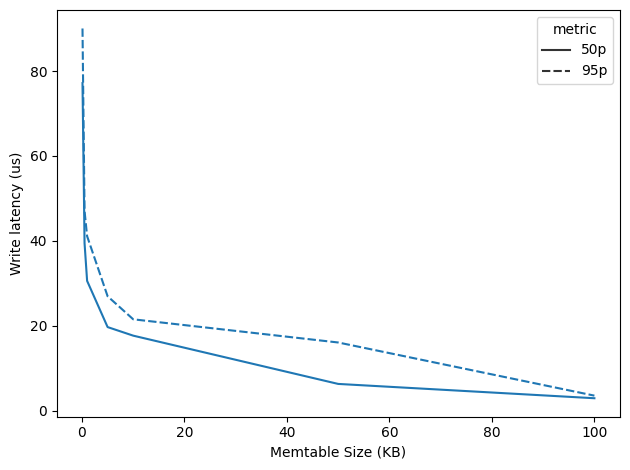

In [1]:
# writes

from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_memtable_bytes_limit(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [100, 500, 1000, 5000, 10000, 50000, 100000],
        'remote': [None]
    }],
    [measure_memtable_bytes_limit], {}
)


data = df[['memtable_bytes_limit', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us
data['memtable_bytes_limit'] = data['memtable_bytes_limit'] /1000

lineplot(data=data, x='memtable_bytes_limit', y='value', style='metric',
         filename='memtable_bytes_limit_write.pdf', xlabel='Memtable Size (KB)',
         ylabel='Write latency (us)')


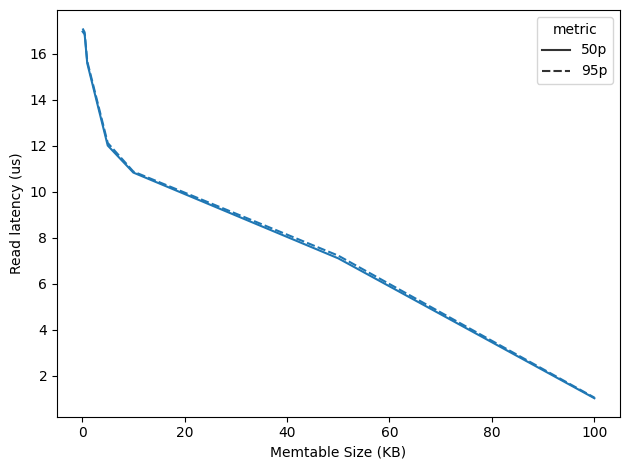

In [2]:
# reads

from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_memtable_bytes_limit(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [100, 500, 1000, 5000, 10000, 50000, 100000],
        'remote': [None]
    }],
    [measure_memtable_bytes_limit], {}
)


data = df[['memtable_bytes_limit', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000
data['memtable_bytes_limit'] = data['memtable_bytes_limit'] /1000

lineplot(data=data, x='memtable_bytes_limit', y='value', style='metric',
         filename='memtable_bytes_limit_read.pdf', xlabel='Memtable Size (KB)',
         ylabel='Read latency (us)')
# keylen: 4, vlen: 4, nitems: 10_000, reading 10Kkeys/sec, uniform distrib, max_runs_per_level: 3, memtable_bytes_limit: 10K, 10second sample for each average latency measurement


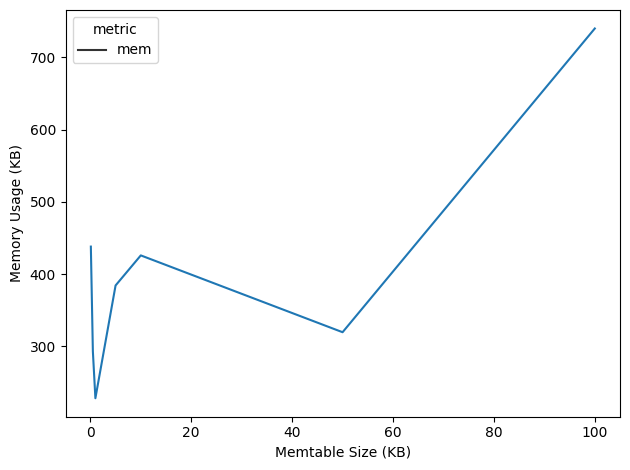

In [4]:
# memory

import sys
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_memtable_bytes_limit(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': 'mem', 'value': sys.getsizeof(db) / 1000})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [3],
        'density_factor': [10],
        'memtable_bytes_limit': [100, 500, 1000, 5000, 10000, 50000, 100000],
        'remote': [None]
    }],
    [measure_memtable_bytes_limit], {}
)


data = df[['memtable_bytes_limit', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['mem'])]
data['memtable_bytes_limit'] = data['memtable_bytes_limit'] /1000

lineplot(data=data, x='memtable_bytes_limit', y='value', style='metric',
         filename='memtable_bytes_limit_mem.pdf', xlabel='Memtable Size (KB)',
         ylabel='Memory Usage (KB)')